# User Input
Only run the needed ones

### Select top camera input video

In [1]:
from tkinter import Tk
from tkinter import filedialog

video_path = filedialog.askopenfilenames()[0] # show an "Open" dialog box and return the path to the selected file
print (video_path)

/Users/chavezmunoz.a/Documents/Dev/antTracking/TransferRate/yolov7/media/shortTop.mp4


### Select bottom camera input video

In [2]:
bottomCamera_path = filedialog.askopenfilenames()[0] # show an "Open" dialog box and return the path to the selected file
print (bottomCamera_path)

/Users/chavezmunoz.a/Documents/Dev/antTracking/TransferRate/yolov7/media/shortBottom.mp4


### Select times

In [3]:
timesFile = filedialog.askopenfilenames()[0] # Select time File
print(timesFile)

/Users/chavezmunoz.a/Documents/Dev/antTracking/TransferRate/yolov7/media/times_experiment1_MV-CH430-90XM-F-NF_from_Hikvision.txt


# Helper Code For Inference


In [4]:
%cd yolov7
import os
import sys
sys.path.append('/yolov7')


import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

/Users/chavezmunoz.a/Documents/Dev/antTracking/TransferRate/yolov7


# Check frame alignment

### Flip images to match

Before:


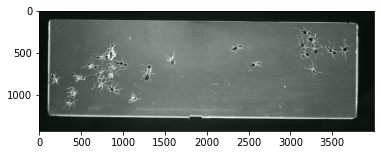

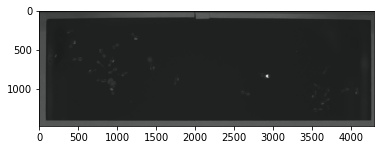

After:


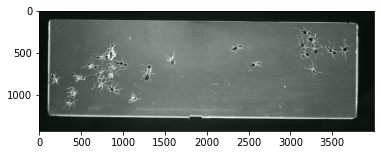

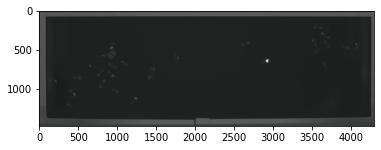

In [5]:

%matplotlib inline
from matplotlib import pyplot as plt

topVideo = cv2.VideoCapture(video_path)
bottomVideo = cv2.VideoCapture(bottomCamera_path)
# Get images
ret, labelImg = topVideo.read()
ret1, imgB = bottomVideo.read()
topVideo.release()
bottomVideo.release()

print('Before:')
plt.imshow(labelImg)
plt.show()
plt.imshow(imgB)
plt.show()

# Rotate images
if ret and ret1:
    fluImg = cv2.flip(imgB, 0)
    

print('After:')
plt.imshow(labelImg)
plt.show()
plt.imshow(fluImg)
plt.show()

### Crop images based on frame

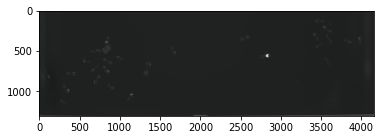

0.3142582351526809


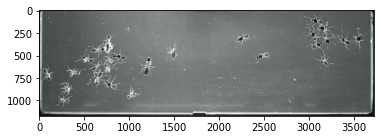

0.31453129196884233


In [6]:
from helperFunctions.rotateAndCut import rotateAndCut
# Align images by rotating and cropping
fluImg,fluoRect = rotateAndCut(fluImg,True)
plt.imshow(fluImg)
plt.show()

# Get ratio to crop the other one based on that
fh,fw=fluImg.shape[:2]
ratioF = fh/fw
print(ratioF)

labelImg,labelRect=rotateAndCut(labelImg,ratio=ratioF)
plt.imshow(labelImg)
plt.show()

lh,lw=labelImg.shape[:2]
ratioL = lh/lw
print(ratioL)

if lh<fh:
    fluImg = cv2.resize(fluImg,(lw,lh)) 
    w=lw
    h=lh
else:
    img0 = cv2.resize(labelImg,(fw,fh))
    w=fw
    h=fh




# Configuration Parameters

Change the path of both **weights** and **yaml** file

In [7]:
classes_to_filter = None  #You can give list of classes to filter by name, Be happy you don't have to put class number. ['train','person' ]


opt  = {
    
    "weights": "best.pt", # Path to weights file default weights are for nano model
    # "yaml"   : "Trash-5/data.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : 'cpu',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

# Process Video

### Get ant positions

In [8]:
import pandas as pd
from helperFunctions.cleanDetection import cleanDetection
from helperFunctions.getFluorescence import getFluorescence
from helperFunctions.append import appendToFile

# Get time stamps
times = pd.read_table(timesFile,header=None).squeeze()

# Initializing video object
video = cv2.VideoCapture(video_path)
bottomVideo = cv2.VideoCapture(bottomCamera_path)
if (video.isOpened()== False) or (bottomVideo.isOpened()== False):
  print("Error opening video stream or file")

#Video information
fps = video.get(cv2.CAP_PROP_FPS)
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

torch.cuda.empty_cache()
# Initializing model and setting it for inference
with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
        model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    classes = None
    if opt['classes']:
        classes = []
        for class_name in opt['classes']:
            classes.append(opt['classes'].index(class_name))

    firstLoop=True
    j = 0
    while True:

        # Get images
        ret, img0 = video.read()
        ret1, imgB = bottomVideo.read()

        if (not ret) or (not ret1):
            print('No more images')
            break
        

        # Crop image based on frame
        fluImg = cv2.flip(imgB, 0)
        fluImg,_rect = rotateAndCut(fluImg,True,rect=fluoRect)
        fluImg = cv2.resize(fluImg,(w,h))
        # Crop image based on ratio
        img0,_rect=rotateAndCut(img0,ratio=ratioF,rect=labelRect)
        img0 = cv2.resize(img0,(w,h))

        if firstLoop:
            firstLoop=False
            # Initialzing object for writing video output
            output = cv2.VideoWriter('results/labels.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
            bottomOutput = cv2.VideoWriter('results/fluorescent.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
            # Create file to save fluorescence
            with open('results/avgFluo.txt', 'w') as f:
                f.write('Time' + "\t" + 'Type' + "\t" + 'Average Intensity')
    
        img = letterbox(img0, imgsz, stride=stride)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]

        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):
            s = ''
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
            if len(det):
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()
                det = cleanDetection(det,names) # Delete 'ants' and replace with 'black' or 'white'
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        
                for *xyxy, conf, cls in reversed(det):
                    # conf = confidence
                    # cls = class idx
                    # xyxy = corner points

                    # Get fluorescence value
                    antType = names[int(cls)]
                    if antType == 'white' or antType == 'black':
                        avgFluo = getFluorescence(fluImg,xyxy)
                        appendToFile('results/avgFluo.txt',str(times[j]) + "\t" + antType + "\t" + str(avgFluo))
            

                    label = f'{names[int(cls)]} {conf:.2f}'
                    plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
                    plot_one_box(xyxy, fluImg, label=label, color=colors[int(cls)], line_thickness=3)
        print(s)    
        j+=1
        print(f"{j+1}/{nframes} frames processed")
        output.write(img0)
        bottomOutput.write(fluImg)
        
bottomOutput.release()
output.release()
video.release()
bottomVideo.release()

YOLOR 🚀 v0.1-104-g941b94c torch 1.12.1 CPU



Fusing layers... 


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/anaconda3/envs/ants/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients, 103.2 GFLOPS


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


224x640 14 blacks, 13 whites, 
2/1096 frames processed
224x640 16 blacks, 11 whites, 
3/1096 frames processed
224x640 14 blacks, 2 larvaes, 12 whites, 
4/1096 frames processed
224x640 13 blacks, 1 larvae, 14 whites, 
5/1096 frames processed
224x640 13 blacks, 12 whites, 
6/1096 frames processed
224x640 12 blacks, 2 larvaes, 14 whites, 
7/1096 frames processed
224x640 13 blacks, 2 larvaes, 12 whites, 
8/1096 frames processed
224x640 14 blacks, 2 larvaes, 12 whites, 
9/1096 frames processed
224x640 16 blacks, 4 larvaes, 10 whites, 
10/1096 frames processed
224x640 14 blacks, 1 larvae, 14 whites, 
11/1096 frames processed
224x640 10 blacks, 1 larvae, 15 whites, 
12/1096 frames processed
224x640 12 blacks, 2 larvaes, 15 whites, 
13/1096 frames processed
224x640 15 blacks, 3 larvaes, 13 whites, 
14/1096 frames processed
224x640 14 blacks, 2 larvaes, 14 whites, 
15/1096 frames processed
224x640 15 blacks, 2 larvaes, 12 whites, 
16/1096 frames processed
224x640 15 blacks, 1 larvae, 12 whites,

### Graph data

### Upload data if reanalyzing

In [9]:
info_path = filedialog.askopenfilenames()[0] # show an "Open" dialog box and return the path to the selected file
print (info_path)

IndexError: string index out of range

### Or use current data

In [10]:
info_path="results/avgFLuo.txt"

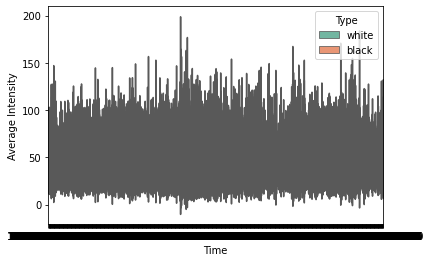

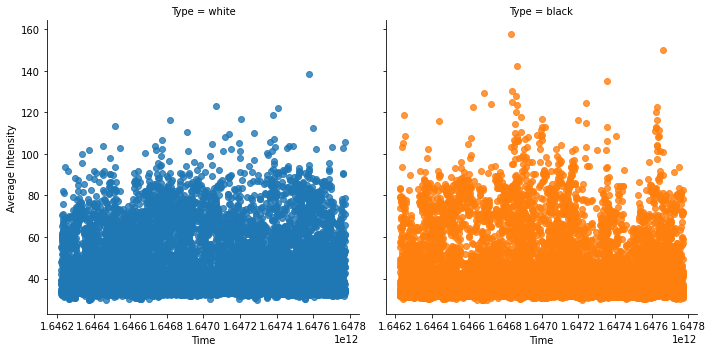

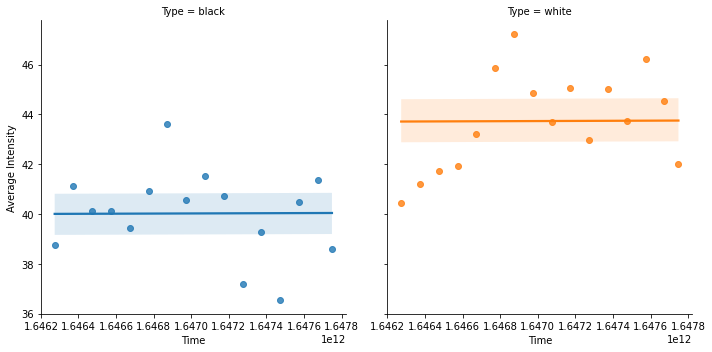

In [11]:
import seaborn as sns
from helperFunctions.compress import compress

df = pd.read_table(info_path, delimiter="\t")


ax = sns.violinplot(x="Time", y="Average Intensity", hue="Type",
                    data=df, palette="Set2", split=True,
                    scale="count", inner="stick")
plt.show()

g = sns.lmplot(x="Time", y="Average Intensity", hue="Type", data=df, col="Type")
plt.show()

df= compress(df,100000000)
g = sns.lmplot(x="Time", y="Average Intensity", hue="Type", data=df, col="Type")

plt.show()